In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
from tqdm.notebook import tqdm

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_Ori2_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 4)


  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [5]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['d', 'theta', 'h', 'phi']
[[-0.54532796  0.19950308  0.2467447  -0.0059728 ]
 [-0.36648332 -0.83769703 -0.33564824  0.30532084]
 [ 0.59473091  0.05853246 -0.31366349  0.12593238]
 ...
 [-0.26264348 -0.37940062  0.95769607  0.84008016]
 [-0.01424659 -0.12016722  0.92645932 -0.25468492]
 [-0.1353533  -0.07019125  0.14896279 -0.97961952]]


In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [7]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:07,  1.03s/it]

Training Loss: 91.27234905213118 Validation Loss: 25.74933325126767


  4%|▎         | 11/300 [00:10<04:37,  1.04it/s]

Training Loss: 67.73464431799948 Validation Loss: 20.96839079260826


  7%|▋         | 21/300 [00:20<04:52,  1.05s/it]

Training Loss: 50.780618007294834 Validation Loss: 16.452987011522055


 10%|█         | 31/300 [00:31<04:43,  1.05s/it]

Training Loss: 38.44625778961927 Validation Loss: 15.905364765319973


 14%|█▎        | 41/300 [00:41<04:33,  1.06s/it]

Training Loss: 29.09581674821675 Validation Loss: 11.199336145073175


 17%|█▋        | 51/300 [00:52<04:20,  1.05s/it]

Training Loss: 23.11742799030617 Validation Loss: 10.592916897498071


 20%|██        | 61/300 [01:02<04:10,  1.05s/it]

Training Loss: 16.53163554519415 Validation Loss: 8.259020191151649


 24%|██▎       | 71/300 [01:13<03:59,  1.04s/it]

Training Loss: 12.81915434054099 Validation Loss: 7.362057686317712


 27%|██▋       | 81/300 [01:23<03:56,  1.08s/it]

Training Loss: 9.004893851466477 Validation Loss: 7.234448542119935


 30%|███       | 91/300 [01:33<03:33,  1.02s/it]

Training Loss: 7.6216585473157465 Validation Loss: 8.049278940306976


 34%|███▎      | 101/300 [01:44<03:23,  1.02s/it]

Training Loss: 6.197558340267278 Validation Loss: 7.938248937018216


 37%|███▋      | 111/300 [01:54<03:15,  1.03s/it]

Training Loss: 6.103149266680703 Validation Loss: 7.303780662594363


 40%|████      | 121/300 [02:04<03:03,  1.03s/it]

Training Loss: 4.653193345991895 Validation Loss: 7.598450193181634


 44%|████▎     | 131/300 [02:14<02:52,  1.02s/it]

Training Loss: 4.245542203192599 Validation Loss: 7.71607655310072


 47%|████▋     | 141/300 [02:25<02:41,  1.02s/it]

Training Loss: 4.896985450526699 Validation Loss: 6.537871466483921


 50%|█████     | 151/300 [02:35<02:33,  1.03s/it]

Training Loss: 2.6864010268473066 Validation Loss: 6.567403735360131


 54%|█████▎    | 161/300 [02:45<02:21,  1.02s/it]

Training Loss: 2.4682990314322524 Validation Loss: 6.714492180151865


 57%|█████▋    | 171/300 [02:55<02:11,  1.02s/it]

Training Loss: 2.3571340478374623 Validation Loss: 6.436950501054525


 60%|██████    | 181/300 [03:06<02:02,  1.03s/it]

Training Loss: 2.546524410514394 Validation Loss: 7.0648596114479005


 64%|██████▎   | 191/300 [03:16<01:52,  1.03s/it]

Training Loss: 2.084688092698343 Validation Loss: 6.634868668392301


 67%|██████▋   | 201/300 [03:26<01:43,  1.04s/it]

Training Loss: 1.7802974295336753 Validation Loss: 6.450212716590613


 70%|███████   | 211/300 [03:37<01:31,  1.02s/it]

Training Loss: 1.554588223749306 Validation Loss: 6.4033201690763235


 74%|███████▎  | 221/300 [03:47<01:21,  1.03s/it]

Training Loss: 1.3117280063015642 Validation Loss: 6.456633805762976


 77%|███████▋  | 231/300 [03:57<01:10,  1.02s/it]

Training Loss: 1.1999004653189331 Validation Loss: 6.365687306039035


 80%|████████  | 241/300 [04:07<00:59,  1.01s/it]

Training Loss: 1.209256665999419 Validation Loss: 6.4758945307694376


 84%|████████▎ | 251/300 [04:18<00:50,  1.03s/it]

Training Loss: 1.0824325140274595 Validation Loss: 6.412568502128124


 87%|████████▋ | 261/300 [04:28<00:40,  1.03s/it]

Training Loss: 0.9888487239004462 Validation Loss: 6.25979047594592


 90%|█████████ | 271/300 [04:38<00:29,  1.03s/it]

Training Loss: 0.9635583875860902 Validation Loss: 6.066637661773711


 94%|█████████▎| 281/300 [04:48<00:19,  1.03s/it]

Training Loss: 0.9782324806365068 Validation Loss: 5.913827906828374


 97%|█████████▋| 291/300 [04:59<00:09,  1.01s/it]

Training Loss: 0.9105207171814982 Validation Loss: 5.8683071250561625


100%|██████████| 300/300 [05:07<00:00,  1.02s/it]


In [8]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.7203625962759617
(128, 4)
(128, 4)


<IPython.core.display.Javascript object>


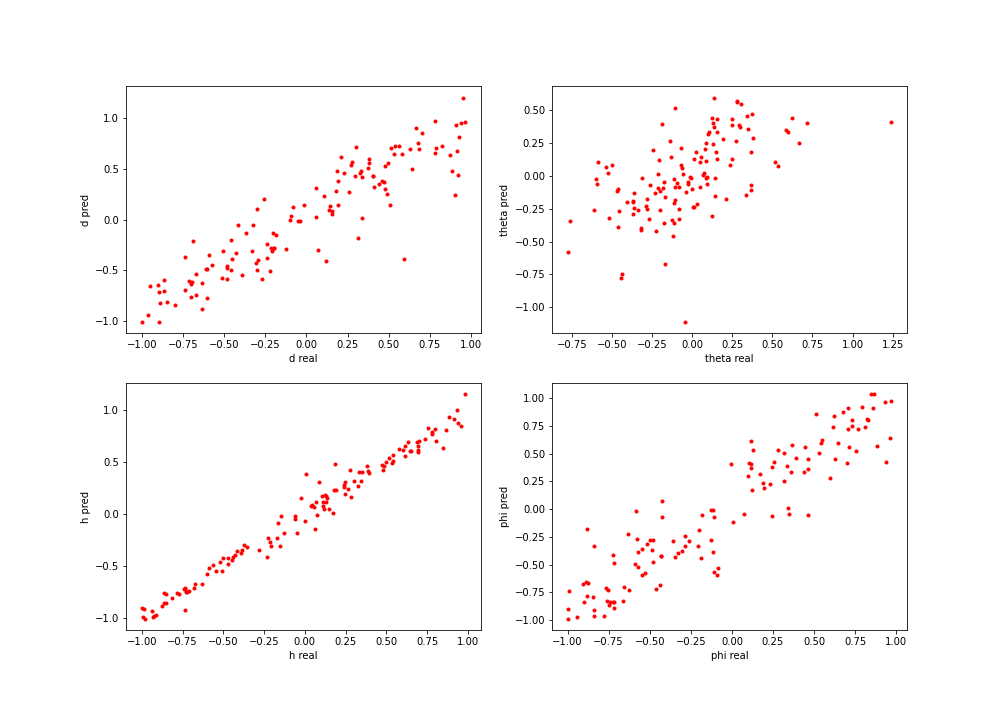

In [9]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

# ax_h = plt.subplot(121)
# ax_h.scatter(h_lab, h_out, c='red', marker='.')
# ax_h.set_xlabel('h real')
# ax_h.set_ylabel('h pred')

# ax_p = plt.subplot(122)
# ax_p.scatter(phi_lab, phi_out, c='red', marker='.')
# ax_p.set_xlabel('phi real')
# ax_p.set_ylabel('phi pred')

ax_d = plt.subplot(221)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(222)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(223)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(224)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

# ax_t = plt.subplot(326)
# ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
# ax_t.set_xlabel('dendrite length real')
# ax_t.set_ylabel('dendrite length pred')

plt.show()

<IPython.core.display.Javascript object>


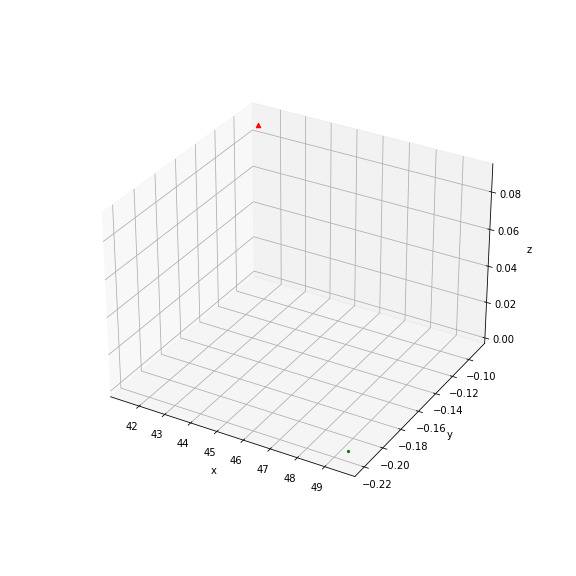

Text(0.5, 0, 'z')

In [8]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()